# Spoken digit classification

For this task, you can use all concepts that you have learned throughout this module in order to obtain a classifier that can determine which digit is heard in an audio file. While you are allowed to use different libraries for visualisation/audio files manipulations purposes, you can only use NumPy to program your classifier; tools from libraries such as **SciPy/SciKit-learn/Keras/PyTorch etc. are not allowed**. However, you may wish to use such libraries as **Librosa, python_speech_features**, etc for audio files manipulation. Please note that your classfier will be tested and compared with classifiers from other students. Experimenting with differnt model approaches, regularisation models & parameters and hyperparameter-tuning strategies such as cross validation is therefore highly recommended.

**The dataset structure**: the dataset consists of recordings of spoken digits in **.wav** files at $8$kHz. The recordings are trimmed so that they have near minimal silence at the beginnings and ends. There are $6$ different speakers who pronounce each digit from $0$ to $9$ for $50$ times. Each audio file has a name of the form $\left\{digit\right\}\_\left\{speaker\,\,name\right\}\_\left\{attempt\,\,number\right\}.wav$. The data is split into training and validation sets with the ratio $80:20$.

There are many ways of representing/visualising the audio data and here in the project we will work with a spectral characteristic known as mel-frequency cepstral coefficients (MFCC) (see [Wikipedia](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) for details). As we will see later this can be treated as an pixel image.

We begin by loading the Audio MNIST training dataset that is taken from this [source](https://github.com/Jakobovski/free-spoken-digit-dataset):

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
audio_mnist_training_mfccs = np.genfromtxt(
    'AudioMNIST/MFCC/Training/training_mfccs.txt')
audio_mnist_training_labels = np.genfromtxt(
    'AudioMNIST/MFCC/Training/training_labels.txt').reshape(-1, 1)

In [3]:
audio_mnist_testing_mfccs = np.genfromtxt(
    'AudioMNIST/MFCC/Testing/testing_mfccs.txt')
audio_mnist_testing_labels = np.genfromtxt(
    'AudioMNIST/MFCC/Testing/testing_labels.txt').reshape(-1, 1)

In [4]:
audio_mnist_mfccs = np.r_[audio_mnist_training_mfccs,audio_mnist_testing_mfccs]
audio_mnist_labels = np.r_[audio_mnist_training_labels,audio_mnist_testing_labels]

In [5]:
classes_dictionary ={}
for i in range(len(audio_mnist_mfccs)):
    key = int(audio_mnist_labels[i])
    if key not in classes_dictionary.keys():
        classes_dictionary[key] = audio_mnist_mfccs[i]
    else:
        classes_dictionary[key] = np.c_[classes_dictionary[key],audio_mnist_mfccs[i]]

**Remark:** Please note that the corresponding data folder contains two types of data:
- raw audio files (folder Audio)
- audio files Mel-frequency cepstral coefficients (folder MFCC) saved in txt file

In the above we use Mel-frequency cepstral coefficients as the data representation of audio. You are allowed to use alternative representations if you wish. If you do so, please comment in your report on why have you selected another model and what have you achieved by doing that.

Below we take a random element of a training data and demonstrate how the MFCC can be visualised.

The Audio MNIST training set contains 2400 samples with 900 MFC coefficients each.


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

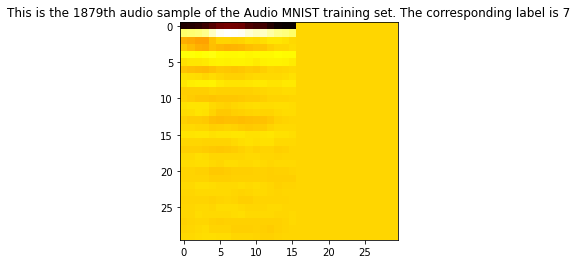

In [6]:
print("The Audio MNIST training set contains {s} samples with {p} MFC coefficients each.".format(s = audio_mnist_training_mfccs.shape[0], \
        p = audio_mnist_training_mfccs.shape[1]))

item_number = np.random.randint(low=0, high=2400)

plt.imshow(audio_mnist_training_mfccs[item_number].reshape(30, 30), cmap='hot')
plt.title("This is the {n}th audio sample of the Audio MNIST training set. The corresponding label is {l}".format( \
            n= item_number, l=int(audio_mnist_training_labels[item_number][0])))
plt.tight_layout

Use the following space to write your codes. It should be possible to reproduce results that are shown in your report with the codes that are described here. You can outsource functions into separate files if you find that this tidies up your notebook. Any additional libraries that you want to use (e.g. for visualisations etc.) can be loaded here.

## Functions

In [7]:
def standardise(data_matrix):
    mean = np.mean(data_matrix, axis=0)
    std = np.std(data_matrix, axis=0)
    standardised_matrix = (data_matrix - mean) / std
    return standardised_matrix, mean, std

def linear_regression_data(data_inputs):
    X = np.ones((len(data_inputs),1))
    X = np.c_[X,data_inputs]
    return X

def linear_model_function(data_matrix, weights):
#     print(data_matrix@weights)
    return data_matrix@weights

def gradient_descent(objective,gradient,initial_weights,step_size=1,no_of_iterations=100,print_output=10):
    objective_values = []
    weights = np.copy(initial_weights)
    objective_values.append(objective(weights))
    for counter in range(no_of_iterations):
        weights -= step_size * gradient(weights)
        objective_values.append(objective(weights))
        if (counter + 1) % print_output == 0:
            print("Iteration {k}/{m}, objective = {o}.".format(k=counter+1, \
            m=no_of_iterations, o=objective_values[counter]))
    print("Iteration completed after {k}/{m}, objective = {o}.".format(k=counter + 1, \
                                                                    m=no_of_iterations, o=objective_values[counter]))
    return weights, objective_values

def gradient_descent_v2(objective, gradient, initial_weights, step_size=1, no_of_iterations=100, print_output=10, \
                        tolerance=1e-6):
    objective_values = []
    weights = np.copy(initial_weights)
    objective_values.append(objective(weights))
    for counter in range(no_of_iterations):
        weights -= step_size * gradient(weights)
        objective_values.append(objective(weights))
        if (counter + 1) % print_output == 0:
            print("Iteration {k}/{m}, objective = {o}.".format(k=counter+1, \
            m=no_of_iterations, o=objective_values[counter]))
        if np.linalg.norm(gradient(weights)) <= tolerance:
            break
    print("Iteration completed after {k}/{m}, objective = {o}.".format(k=counter + 1, \
                                                                    m=no_of_iterations, o=objective_values[counter]))
    return weights, objective_values

def proximal_gradient_descent(objective,gradient,proximal_map,initial_weights,step_size=1,no_of_iterations=1000,
                              print_output=100):
    objective_values = []
    weights = np.copy(initial_weights)
    objective_values.append(objective(weights))
    for counter in range(no_of_iterations):
        weights = proximal_map(weights - step_size * gradient(weights))
        objective_values.append(objective(weights))
        if (counter + 1) % print_output == 0:
            print("Iteration {k}/{m}, objective = {o}.".format(k=counter+1, \
            m=no_of_iterations, o=objective(weights)))
    print("Iteration completed after {k}/{m}, objective = {o}.".format(k=counter + 1, \
                                                                    m=no_of_iterations, o=objective_values[counter]))
    return weights, objective_values

def soft_thresholding(argument, threshold):
#     print('argument: ', argument)
#     print('threshold: ', threshold)
    return np.sign(argument) * np.maximum(0, np.abs(argument) - threshold)

def softmax_function(argument, axis=None):
    if axis == None:
        output = np.exp(argument - np.max(argument))
        output = output / np.sum(output)
    else:
        output = np.exp(argument - np.expand_dims(np.max(argument, axis), axis))
        output = output / np.expand_dims(np.sum(output, axis), axis)
    return output

def one_hot_vector_encoding_mnist(labels):
    mnist_labels = np.concatenate(labels)
    no_of_classes = int(np.max(mnist_labels)) + 1
    output = np.zeros((len(mnist_labels), no_of_classes))
    output[np.arange(len(mnist_labels)).astype(int), mnist_labels.astype(int)] = 1
    return output

def grid_search(objective, grid):
    values = np.array([])
    for point in grid:
        values = np.append(values, objective(point))
    print(values)
#         print(grid[np.argmin(values)])
    return grid[np.argmin(values)]

def classification_accuracy(true_labels, recovered_labels):
#     equal_labels = np.array([true_labels[n] == recovered_labels[n] for n in range(len(recovered_labels))])
    equal_labels = true_labels == recovered_labels
#     print(np.mean(equal_labels))
    return np.mean(equal_labels)

## Neural Network Functions

In [8]:
def nn_forward_propagation(data_input, weight_matrix):
    no_of_layers = weight_matrix.shape[0]
    nn_state = np.empty(2*no_of_layers+1, dtype = np.ndarray)
    nn_state[0] = data_input
    for l in range(no_of_layers):
        nn_state[2*l+1] = linear_model_function(linear_regression_data(nn_state[2*l]),weight_matrix[l])
        nn_state[2*l+2] = softmax_function(nn_state[2*l+1], axis = 1)
    return nn_state

def nn_back_propagation(data_input, weight_matrix, one_hot_vector_encodings):
        
    nn_state = nn_forward_propagation(data_input, weight_matrix)
    no_of_layers = weight_matrix.shape[0]
    
    full_X_gradient = np.empty(no_of_layers, dtype = np.ndarray)
    full_W_gradient = np.empty(no_of_layers, dtype = np.ndarray)
    full_Z_gradient = np.empty(no_of_layers, dtype = np.ndarray)
    
    full_Z_gradient[no_of_layers-1] = nn_state[-1] - one_hot_vector_encodings
    
    for layer in range(no_of_layers,0,-1):
        full_W_gradient[layer-1] = linear_regression_data(nn_state[2*layer-2]).T @ full_Z_gradient[layer-1]
        full_X_gradient[layer-1] = full_Z_gradient[layer-1] @ (np.delete(weight_matrix[layer-1],(0), axis = 0)).T
    
        if layer != 1:
            product_matrix = full_X_gradient[layer-1]*nn_state[2*layer-2]
            sigma_matrix = np.sum(product_matrix,axis=1)
            full_Z_gradient[layer-2] = product_matrix - (nn_state[2*layer-2].T*sigma_matrix).T
        
    return full_W_gradient

def nn_cost_function(data_input, weight_matrix, one_hot_vector_encodings):
    nn_state = nn_forward_propagation(data_input, weight_matrix)
    return np.sum(np.log(np.sum(np.exp(nn_state[-2]), axis=1))\
                  - np.sum(one_hot_vector_encodings*nn_state[-2], axis=1))

def nn_prediction_function(data_input, weight_matrix):
    nn_state = nn_forward_propagation(data_input, weight_matrix)
    return np.argmax(nn_state[-1], axis=1)

def nn_cost_function_ridge(data_input, weight_matrix, one_hot_vector_encodings,regularisation_parameter):
    return nn_cost_function(data_input, weight_matrix, one_hot_vector_encodings) + \
                                                    (regularisation_parameter/2)*np.linalg.norm(weight_matrix)**2

def nn_cost_function_LASSO(data_input, weight_matrix, one_hot_vector_encodings,regularisation_parameter):
    return nn_cost_function(data_input, weight_matrix, one_hot_vector_encodings) + \
                                                    regularisation_parameter*np.sum(np.abs(weight_matrix))

In [9]:
def MNIST_multinomial_logistic_model_function(input_data, input_labels):
    '''Multinomial Logistic Regression.'''

    audio_mnist_data, _, _ = standardise(input_data)

    audio_mnist_data_matrix = linear_regression_data(audio_mnist_data)

    audio_mnist_OHV = one_hot_vector_encoding_mnist(input_labels)

    audio_mnist_objective = lambda weight_matrix: multinomial_logistic_regression_cost_function(\
                                                                                    audio_mnist_data_matrix,\
                                                                                    weight_matrix,\
                                                                                    audio_mnist_OHV)


    audio_mnist_gradient = lambda weight_matrix: multinomial_logistic_regression_gradient(\
                                                                                    audio_mnist_data_matrix,\
                                                                                    weight_matrix,\
                                                                                    audio_mnist_OHV)

    audio_mnist_initial_weights = np.zeros(shape=(len(audio_mnist_data_matrix.T),10))

    audio_mnist_step_size = (3.9*len(audio_mnist_data_matrix))/(np.linalg.norm(\
                                                                                audio_mnist_data_matrix)**2)

    audio_mnist_optimal_weights, audio_mnist_objective_values = gradient_descent_v2(audio_mnist_objective, \
                                                                                    audio_mnist_gradient, \
                                                                                    audio_mnist_initial_weights,\
                                                                                    audio_mnist_step_size, \
                                                                                    no_of_iterations=2000, \
                                                                                    print_output=2000, \
                                                                                    tolerance=1e-3)
    
    labels = multinomial_prediction_function(audio_mnist_data_matrix, audio_mnist_optimal_weights)
    
    return labels

In [10]:
def MNIST_ridge_multinomial_logistic_model_function(input_data, input_labels, regularisation_parameter=1e-4):
    
    audio_mnist_ridge_regularisation_parameter = regularisation_parameter

    audio_mnist_data = standardise(input_data)[0]

    audio_mnist_ridge_training_data_matrix = linear_regression_data(audio_mnist_data) 

    audio_mnist_OHV = one_hot_vector_encoding_mnist(input_labels)

    audio_mnist_ridge_objective = lambda weight_matrix: ridge_multinomial_logistic_regression_cost_function(\
                                                                      audio_mnist_ridge_training_data_matrix,\
                                                                      weight_matrix,audio_mnist_OHV,\
                                                                      audio_mnist_ridge_regularisation_parameter) 

    audio_mnist_ridge_gradient = lambda weight_matrix: ridge_multinomial_logistic_regression_gradient(\
                                                                        audio_mnist_ridge_training_data_matrix,\
                                                                        weight_matrix,audio_mnist_OHV, \
                                                                        audio_mnist_ridge_regularisation_parameter) 

    audio_mnist_ridge_initial_weights = np.zeros(shape=(len(audio_mnist_ridge_training_data_matrix.T),10)) 

    audio_mnist_ridge_step_size = (3.9*len(audio_mnist_ridge_training_data_matrix))/(np.linalg.norm(\
                                                                        audio_mnist_ridge_training_data_matrix)**2)

    audio_mnist_ridge_optimal_weights, audio_mnist_ridge_objective_values = gradient_descent_v2(\
                                                                        audio_mnist_ridge_objective, \
                                                                        audio_mnist_ridge_gradient, \
                                                                        audio_mnist_ridge_initial_weights,\
                                                                        step_size = audio_mnist_ridge_step_size, \
                                                                        no_of_iterations=2000, \
                                                                        print_output=2000, \
                                                                        tolerance=1e-5)
    
    labels = multinomial_prediction_function(audio_mnist_ridge_training_data_matrix, \
                                             audio_mnist_ridge_optimal_weights)
    
    return labels

In [11]:
def MNIST_LASSO_multinomial_logistic_model_function(input_data, input_labels, regularisation_parameter):
    '''LASSO Multinomial Logistic Regression.'''

    audio_mnist_LASSO_regularisation_parameter = regularisation_parameter
    
    audio_mnist_data, _, _ = standardise(input_data)

    audio_mnist_LASSO_data_matrix = linear_regression_data(audio_mnist_data) 

    audio_mnist_OHV = one_hot_vector_encoding_mnist(input_labels)

    audio_mnist_LASSO_objective = lambda weight_matrix: lasso_logistic_regression_cost_function(\
                                                                      audio_mnist_LASSO_data_matrix,\
                                                                      weight_matrix,audio_mnist_OHV,\
                                                                      audio_mnist_LASSO_regularisation_parameter) 
        
    audio_mnist_LASSO_gradient = lambda weight_matrix: multinomial_logistic_regression_gradient(\
                                                                        audio_mnist_LASSO_data_matrix,\
                                                                        weight_matrix,audio_mnist_OHV) 

    audio_mnist_LASSO_initial_weights = np.zeros(shape=(len(audio_mnist_LASSO_data_matrix.T),10)) 

    audio_mnist_LASSO_step_size = (3.9*len(audio_mnist_LASSO_data_matrix))/(np.linalg.norm(\
                                                                        audio_mnist_LASSO_data_matrix)**2)

    audio_mnist_proximal_map = lambda weights: soft_thresholding(weights, audio_mnist_LASSO_regularisation_parameter*\
                                                                 audio_mnist_LASSO_step_size)

    audio_mnist_LASSO_optimal_weights, audio_mnist_LASSO_objective_values = proximal_gradient_descent(\
                                                                audio_mnist_LASSO_objective, \
                                                                audio_mnist_LASSO_gradient, audio_mnist_proximal_map,\
                                                                audio_mnist_LASSO_initial_weights, \
                                                                audio_mnist_LASSO_step_size, \
                                                                no_of_iterations=2000, print_output=2000)
    
    labels = multinomial_prediction_function(audio_mnist_LASSO_data_matrix, audio_mnist_LASSO_optimal_weights)
    
    return labels

In [12]:
def MNIST_ridge_multinomial_logistic_model_function_nn(input_data, input_labels, regularisation_parameter=1e-4):

    no_of_layers = 1

    audio_mnist_ridge_regularisation_parameter = regularisation_parameter

    audio_mnist_training_data = standardise(input_data)[0]

    audio_mnist_training_data_matrix = linear_regression_data(audio_mnist_training_data)

    audio_mnist_OHV = one_hot_vector_encoding_mnist(input_labels)


    audio_mnist_nn_objective = lambda weight_matrix: nn_cost_function_ridge(audio_mnist_training_data,\
                                                               weight_matrix,\
                                                               audio_mnist_OHV,\
                                                                audio_mnist_ridge_regularisation_parameter)

    audio_mnist_nn_gradient = lambda weight_matrix: nn_back_propagation(audio_mnist_training_data,\
                                                                 weight_matrix,\
                                                                 audio_mnist_OHV)

    audio_mnist_nn_step = 3.9/(np.linalg.norm(audio_mnist_training_data_matrix, 2) ** 2)

    audio_mnist_nn_initial_weight_matrix = np.empty(no_of_layers, dtype = np.ndarray)

    for i in range(no_of_layers - 1):
        audio_mnist_nn_initial_weight_matrix[i] = np.zeros((audio_mnist_training_data.shape[1]+1,\
                                                     audio_mnist_training_data.shape[1]))

    audio_mnist_nn_initial_weight_matrix[no_of_layers - 1] = np.zeros((audio_mnist_training_data.shape[1]+1,\
                                                                       audio_mnist_OHV.shape[1]))

    audio_mnist_nn_optimal_weights = gradient_descent(\
                                        audio_mnist_nn_objective, \
                                        audio_mnist_nn_gradient, \
                                        audio_mnist_nn_initial_weight_matrix,\
                                        step_size = audio_mnist_nn_step, \
                                        no_of_iterations=2000, \
                                        print_output=1000)[0]


    audio_mnist_nn_accuracy_rate = classification_accuracy(np.concatenate(input_labels),
                                                           nn_prediction_function(audio_mnist_training_data, \
                                                                            audio_mnist_nn_optimal_weights))

    
    labels = nn_prediction_function(audio_mnist_training_data_matrix, audio_mnist_nn_optimal_weights)
    
    return labels

## Multinomial Logistic Regression

In [13]:
def multinomial_logistic_regression_cost_function(data_matrix, weight_matrix,
                                                  one_hot_vector_encodings):
    prediction = data_matrix@weight_matrix
    return (1/len(data_matrix)*(np.sum(np.log(np.sum(np.exp(prediction), axis=1)) - np.sum(one_hot_vector_encodings\
                                                                            *prediction, axis=1))))

In [14]:
def multinomial_logistic_regression_gradient(data_matrix, weight_matrix,
                                             one_hot_vector_encodings):
    output = (1/len(data_matrix))*(data_matrix.T@(softmax_function(data_matrix@weight_matrix, axis=1) - \
                                               one_hot_vector_encodings))
#     print(output)
    return output

In [15]:
def multinomial_prediction_function(data_matrix, weight_matrix):
    return np.argmax(data_matrix@weight_matrix, axis=1)

In [16]:
# Multinomial Logistic Regression Training Only

audio_mnist_training_data = standardise(audio_mnist_training_mfccs)[0]

audio_mnist_training_data_matrix = linear_regression_data(audio_mnist_training_data)

audio_mnist_OHV = one_hot_vector_encoding_mnist(audio_mnist_training_labels)

audio_mnist_objective = lambda weight_matrix: multinomial_logistic_regression_cost_function(\
                                                                                audio_mnist_training_data_matrix,\
                                                                                weight_matrix,\
                                                                                audio_mnist_OHV)


audio_mnist_gradient = lambda weight_matrix: multinomial_logistic_regression_gradient(\
                                                                                audio_mnist_training_data_matrix,\
                                                                                weight_matrix,\
                                                                                audio_mnist_OHV)

audio_mnist_initial_weights = np.zeros(shape=(len(audio_mnist_training_data_matrix.T),10))

audio_mnist_step_size = (3.9*len(audio_mnist_training_data_matrix))/(np.linalg.norm(\
                                                                            audio_mnist_training_data_matrix)**2)

audio_mnist_optimal_weights, audio_mnist_objective_values = gradient_descent_v2(audio_mnist_objective, \
                                                                                audio_mnist_gradient, \
                                                                                audio_mnist_initial_weights,\
                                                                                audio_mnist_step_size, \
                                                                                no_of_iterations=2000, \
                                                                                print_output=200, \
                                                                                tolerance=1e-3)


Iteration 200/2000, objective = 0.5451678844894882.
Iteration 400/2000, objective = 0.3440759627875746.
Iteration 600/2000, objective = 0.2638097624142257.
Iteration 800/2000, objective = 0.218831518095195.
Iteration 1000/2000, objective = 0.18929079559559858.
Iteration 1200/2000, objective = 0.16804109955129592.
Iteration 1400/2000, objective = 0.15183825700013626.
Iteration 1600/2000, objective = 0.13897645581661028.
Iteration 1800/2000, objective = 0.1284618170671333.
Iteration 2000/2000, objective = 0.11967008369792075.
Iteration completed after 2000/2000, objective = 0.11967008369792075.


In [17]:
# Multinomial Regression Classification Accuracy Training Only

audio_mnist_recovered_labels = multinomial_prediction_function(audio_mnist_training_data_matrix, \
                                                               audio_mnist_optimal_weights)

audio_mnist_classification_accuracy = classification_accuracy(np.concatenate(audio_mnist_training_labels), \
                                                              audio_mnist_recovered_labels)

print("The classification accuracy for the audio_mnist training dataset is {p} %.".format(\
                                                                    p=100 * audio_mnist_classification_accuracy))

The classification accuracy for the audio_mnist training dataset is 98.58333333333333 %.


In [18]:
# Multinomial Regression Classification Accuracy Testing

audio_mnist_testing_data = standardise(audio_mnist_testing_mfccs)[0]

audio_mnist_testing_data_matrix = linear_regression_data(audio_mnist_testing_data)

audio_mnist_recovered_labels = multinomial_prediction_function(audio_mnist_testing_data_matrix, \
                                                               audio_mnist_optimal_weights)

audio_mnist_classification_accuracy_test = classification_accuracy(np.concatenate(audio_mnist_testing_labels), \
                                                              audio_mnist_recovered_labels)

print("The classification accuracy for the audio_mnist testing dataset is {p} %.".format(\
                                                                    p=100 * audio_mnist_classification_accuracy_test))

The classification accuracy for the audio_mnist testing dataset is 94.33333333333334 %.


In [19]:
# Multinomial Neural Network

no_of_layers = 1

audio_mnist_training_data = standardise(audio_mnist_training_mfccs)[0]

audio_mnist_training_data_matrix = linear_regression_data(audio_mnist_training_data)

audio_mnist_OHV = one_hot_vector_encoding_mnist(audio_mnist_training_labels)

audio_mnist_nn_objective = lambda weight_matrix: nn_cost_function(audio_mnist_training_data,\
                                                           weight_matrix,\
                                                           audio_mnist_OHV)

audio_mnist_nn_gradient = lambda weight_matrix: nn_back_propagation(audio_mnist_training_data,\
                                                             weight_matrix,\
                                                             audio_mnist_OHV)

audio_mnist_nn_step = 3.9/(np.linalg.norm(audio_mnist_training_data_matrix, 2) ** 2)

audio_mnist_nn_initial_weight_matrix = np.empty(no_of_layers, dtype = np.ndarray)

audio_mnist_nn_initial_weight_matrix[no_of_layers - 1] = np.zeros((audio_mnist_training_data.shape[1]+1,\
                                                                   audio_mnist_OHV.shape[1]))

audio_mnist_nn_optimal_weights = gradient_descent(audio_mnist_nn_objective,audio_mnist_nn_gradient,\
                                                  audio_mnist_nn_initial_weight_matrix,\
                                                  step_size=audio_mnist_nn_step, \
                                                  no_of_iterations=2000, print_output=200)[0]

audio_mnist_nn_accuracy_rate = classification_accuracy(np.concatenate(audio_mnist_training_labels),
                                                       nn_prediction_function(audio_mnist_training_data, \
                                                                        audio_mnist_nn_optimal_weights))

Iteration 200/2000, objective = 296.77807354488596.
Iteration 400/2000, objective = 183.89462896727153.
Iteration 600/2000, objective = 137.20333571002507.
Iteration 800/2000, objective = 110.60128425983858.
Iteration 1000/2000, objective = 93.05960809784006.
Iteration 1200/2000, objective = 80.4851920780418.
Iteration 1400/2000, objective = 70.96986527004847.
Iteration 1600/2000, objective = 63.48859706054527.
Iteration 1800/2000, objective = 57.436756424822555.
Iteration 2000/2000, objective = 52.433275034760676.
Iteration completed after 2000/2000, objective = 52.433275034760676.


In [20]:
print("The one layered neural network successfully classified {acc:2.2f} % of training data"\
      .format(acc = 100 * audio_mnist_nn_accuracy_rate))

The one layered neural network successfully classified 99.92 % of training data


In [21]:
audio_mnist_testing_data = standardise(audio_mnist_testing_mfccs)[0]

audio_mnist_testing_data_matrix = linear_regression_data(audio_mnist_testing_data)

audio_mnist_nn_accuracy_rate_testing = classification_accuracy(np.concatenate(audio_mnist_testing_labels),
                                                       nn_prediction_function(audio_mnist_testing_data, \
                                                                        audio_mnist_nn_optimal_weights))

print("The one layered neural network successfully classified {acc:2.2f} % of testing data"\
      .format(acc = 100 * audio_mnist_nn_accuracy_rate_testing))

The one layered neural network successfully classified 95.00 % of testing data


## Ridge Regression

In [22]:
def ridge_multinomial_logistic_regression_cost_function(data_matrix,
                                                   weights, OHV,
                                                   regularisation_parameter):
    
    return multinomial_logistic_regression_cost_function(data_matrix, weights,OHV) + \
            (regularisation_parameter/2)*np.linalg.norm(weights)**2

In [23]:
def ridge_multinomial_logistic_regression_gradient(data_matrix,
                                              weights, OHV, regularisation_parameter):
    
    return multinomial_logistic_regression_gradient(data_matrix, weights,OHV) + regularisation_parameter*weights

In [24]:
# OPTIMAL ALPHA GRID SEARCH
mnist_regularisation_parameter_grid = np.array([1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])

mnist_classification_error = lambda regularisation_parameter: 1 - classification_accuracy(\
                                np.concatenate(audio_mnist_training_labels),\
                                MNIST_ridge_multinomial_logistic_model_function(\
                                audio_mnist_training_mfccs,audio_mnist_training_labels,regularisation_parameter))

mnist_optimal_regularisation_parameter = grid_search(mnist_classification_error, mnist_regularisation_parameter_grid)

Iteration 2000/2000, objective = 0.11967008411295696.
Iteration completed after 2000/2000, objective = 0.11967008411295696.
Iteration 2000/2000, objective = 0.11967008784828301.
Iteration completed after 2000/2000, objective = 0.11967008784828301.
Iteration 2000/2000, objective = 0.11967012520154109.
Iteration completed after 2000/2000, objective = 0.11967012520154109.
Iteration 2000/2000, objective = 0.11967049873391165.
Iteration completed after 2000/2000, objective = 0.11967049873391165.
Iteration 2000/2000, objective = 0.11967423403657505.
Iteration completed after 2000/2000, objective = 0.11967423403657505.
Iteration 2000/2000, objective = 0.11971158495912146.
Iteration completed after 2000/2000, objective = 0.11971158495912146.
Iteration 2000/2000, objective = 0.12008488391001451.
Iteration completed after 2000/2000, objective = 0.12008488391001451.
Iteration 2000/2000, objective = 0.12379697943804854.
Iteration completed after 2000/2000, objective = 0.12379697943804854.
Iteratio

In [25]:
# Ridge Multinomial Logistic Regression 
audio_mnist_ridge_regularisation_parameter = mnist_optimal_regularisation_parameter

audio_mnist_data = standardise(audio_mnist_training_mfccs)[0]

audio_mnist_ridge_training_data_matrix = linear_regression_data(audio_mnist_data) 

audio_mnist_OHV = one_hot_vector_encoding_mnist(audio_mnist_training_labels)

audio_mnist_ridge_objective = lambda weight_matrix: ridge_multinomial_logistic_regression_cost_function(\
                                                                  audio_mnist_ridge_training_data_matrix,\
                                                                  weight_matrix,audio_mnist_OHV,\
                                                                  audio_mnist_ridge_regularisation_parameter) 

audio_mnist_ridge_gradient = lambda weight_matrix: ridge_multinomial_logistic_regression_gradient(\
                                                                    audio_mnist_ridge_training_data_matrix,\
                                                                    weight_matrix,audio_mnist_OHV, \
                                                                    audio_mnist_ridge_regularisation_parameter) 

audio_mnist_ridge_initial_weights = np.zeros(shape=(len(audio_mnist_ridge_training_data_matrix.T),10)) 

audio_mnist_ridge_step_size = (3.9*len(audio_mnist_ridge_training_data_matrix))/(np.linalg.norm(\
                                                                        audio_mnist_ridge_training_data_matrix)**2)

audio_mnist_ridge_optimal_weights, audio_mnist_ridge_objective_values = gradient_descent(\
                                                                        audio_mnist_ridge_objective, \
                                                                        audio_mnist_ridge_gradient, \
                                                                        audio_mnist_ridge_initial_weights,\
                                                                        step_size = audio_mnist_ridge_step_size, \
                                                                        no_of_iterations=2000, \
                                                                        print_output=200)

Iteration 200/2000, objective = 0.5451678845738082.
Iteration 400/2000, objective = 0.3440759629352873.
Iteration 600/2000, objective = 0.26380976261093164.
Iteration 800/2000, objective = 0.21883151833308084.
Iteration 1000/2000, objective = 0.1892907958696583.
Iteration 1200/2000, objective = 0.16804109985798218.
Iteration 1400/2000, objective = 0.15183825733675965.
Iteration 1600/2000, objective = 0.13897645618103374.
Iteration 1800/2000, objective = 0.1284618174576015.
Iteration 2000/2000, objective = 0.11967008411295696.
Iteration completed after 2000/2000, objective = 0.11967008411295696.


In [26]:
# Ridge Classification Accuracy Testing with Grid Search Optimal Alpha

audio_mnist_ridge_recovered_labels = multinomial_prediction_function(audio_mnist_ridge_training_data_matrix, \
                                                                     audio_mnist_ridge_optimal_weights)

audio_mnist_ridge_classification_accuracy = classification_accuracy(np.concatenate(audio_mnist_training_labels), \
                                                                    audio_mnist_ridge_recovered_labels)

print("The ridge classification accuracy for the audio_mnist_training dataset is {p} %.".format(
    p=100 * audio_mnist_ridge_classification_accuracy))

The ridge classification accuracy for the audio_mnist_training dataset is 98.58333333333333 %.


In [27]:
# Ridge Classification Accuracy Testing with Grid Search Optimal Alpha

audio_mnist_testing_data = standardise(audio_mnist_testing_mfccs)[0]

audio_mnist_ridge_testing_data_matrix = linear_regression_data(audio_mnist_testing_data)

audio_mnist_ridge_recovered_labels = multinomial_prediction_function(audio_mnist_ridge_testing_data_matrix, \
                                                               audio_mnist_ridge_optimal_weights)

audio_mnist_ridge_classification_accuracy_test = classification_accuracy(np.concatenate(audio_mnist_testing_labels), \
                                                              audio_mnist_ridge_recovered_labels)

print("The classification accuracy for the audio_mnist_testing dataset is {p} %.".format(\
                                                             p=100 * audio_mnist_ridge_classification_accuracy_test))

The classification accuracy for the audio_mnist_testing dataset is 94.33333333333334 %.


In [34]:
# Ridge Regularised Neural Network

no_of_layers = 1

audio_mnist_ridge_regularisation_parameter = mnist_optimal_regularisation_parameter

audio_mnist_training_data = standardise(audio_mnist_training_mfccs)[0]

audio_mnist_training_data_matrix = linear_regression_data(audio_mnist_training_data)

audio_mnist_OHV = one_hot_vector_encoding_mnist(audio_mnist_training_labels)


audio_mnist_nn_objective = lambda weight_matrix: nn_cost_function_ridge(audio_mnist_training_data,\
                                                           weight_matrix,\
                                                           audio_mnist_OHV,\
                                                            audio_mnist_ridge_regularisation_parameter)

audio_mnist_nn_gradient = lambda weight_matrix: nn_back_propagation(audio_mnist_training_data,\
                                                             weight_matrix,\
                                                             audio_mnist_OHV)

audio_mnist_nn_step = 3.9/(np.linalg.norm(audio_mnist_training_data_matrix, 2) ** 2)

audio_mnist_nn_initial_weight_matrix = np.empty(no_of_layers, dtype = np.ndarray)

for i in range(no_of_layers - 1):
    audio_mnist_nn_initial_weight_matrix[i] = np.zeros((audio_mnist_training_data.shape[1]+1,\
                                                 audio_mnist_training_data.shape[1]))
    
audio_mnist_nn_initial_weight_matrix[no_of_layers - 1] = np.zeros((audio_mnist_training_data.shape[1]+1,\
                                                                   audio_mnist_OHV.shape[1]))

audio_mnist_ridge_nn_optimal_weights = gradient_descent(\
                                    audio_mnist_nn_objective, \
                                    audio_mnist_nn_gradient, \
                                    audio_mnist_nn_initial_weight_matrix,\
                                    step_size = audio_mnist_nn_step, \
                                    no_of_iterations=2000, \
                                    print_output=20000)[0]


audio_mnist_ridge_nn_accuracy_rate = classification_accuracy(np.concatenate(audio_mnist_training_labels),
                                                       nn_prediction_function(audio_mnist_training_data, \
                                                                        audio_mnist_nn_optimal_weights))

Iteration completed after 2000/2000, objective = [[52.43327503 52.43327503 52.43327503 ... 52.43327503 52.43327503
  52.43327503]
 [52.43327503 52.43327503 52.43327503 ... 52.43327503 52.43327503
  52.43327503]
 [52.43327503 52.43327503 52.43327503 ... 52.43327503 52.43327503
  52.43327503]
 ...
 [52.43327503 52.43327503 52.43327503 ... 52.43327503 52.43327503
  52.43327503]
 [52.43327503 52.43327503 52.43327503 ... 52.43327503 52.43327503
  52.43327503]
 [52.43327503 52.43327503 52.43327503 ... 52.43327503 52.43327503
  52.43327503]].


In [35]:
print("The one layered neural network successfully classified {acc:2.2f} % of training data"\
      .format(acc = 100 * audio_mnist_ridge_nn_accuracy_rate))

The one layered neural network successfully classified 99.92 % of training data


In [36]:
audio_mnist_testing_data = standardise(audio_mnist_testing_mfccs)[0]

audio_mnist_testing_data_matrix = linear_regression_data(audio_mnist_testing_data)

audio_mnist_ridge_nn_accuracy_rate_testing = classification_accuracy(np.concatenate(audio_mnist_testing_labels),
                                                       nn_prediction_function(audio_mnist_testing_data, \
                                                                        audio_mnist_nn_optimal_weights))

print("The one layered neural network successfully classified {acc:2.2f} % of testing data"\
      .format(acc = 100 * audio_mnist_nn_accuracy_rate_testing))

The one layered neural network successfully classified 95.00 % of testing data


## LASSO Multinomial Logistic Regression

In [37]:
def lasso_logistic_regression_cost_function(data_matrix, weight_matrix,one_hot_vector_encodings,
                                            regularisation_parameter):
    return  multinomial_logistic_regression_cost_function(data_matrix, weight_matrix,one_hot_vector_encodings) + \
            regularisation_parameter*np.sum(np.abs(weight_matrix))

In [38]:
def multinomial_logistic_regression_gradient(data_matrix, weight_matrix,
                                             one_hot_vector_encodings):
    output = (1/len(data_matrix))*(data_matrix.T@(softmax_function(data_matrix@weight_matrix, axis=1) - \
                                               one_hot_vector_encodings))
#     print(output)
    return output

In [39]:
# OPTIMAL ALPHA GRID SEARCH
mnist_regularisation_parameter_grid = np.array([1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])

mnist_classification_error = lambda regularisation_parameter: 1 - classification_accuracy(\
                                np.concatenate(audio_mnist_training_labels),\
                                MNIST_LASSO_multinomial_logistic_model_function(\
                                audio_mnist_training_mfccs,audio_mnist_training_labels,regularisation_parameter))

mnist_optimal_regularisation_parameter = grid_search(mnist_classification_error, mnist_regularisation_parameter_grid)

Iteration 2000/2000, objective = 0.11962971482807293.
Iteration completed after 2000/2000, objective = 0.11967010408173288.
Iteration 2000/2000, objective = 0.11962989830797069.
Iteration completed after 2000/2000, objective = 0.11967028753599215.
Iteration 2000/2000, objective = 0.11963173310337336.
Iteration completed after 2000/2000, objective = 0.11967212207501295.
Iteration 2000/2000, objective = 0.11965008069978766.
Iteration completed after 2000/2000, objective = 0.11969046710783879.
Iteration 2000/2000, objective = 0.11983352054717637.
Iteration completed after 2000/2000, objective = 0.11987388132634322.
Iteration 2000/2000, objective = 0.12166431484320389.
Iteration completed after 2000/2000, objective = 0.12170442091773452.
Iteration 2000/2000, objective = 0.13961236283011327.
Iteration completed after 2000/2000, objective = 0.1396501075463546.
Iteration 2000/2000, objective = 0.2889844523487539.
Iteration completed after 2000/2000, objective = 0.2890106709860738.
Iteration 2

In [40]:
# LASSO Multinomial Logistic Regression Training Only with Grid Search

audio_mnist_LASSO_regularisation_parameter = mnist_optimal_regularisation_parameter

audio_mnist_data = standardise(audio_mnist_training_mfccs)[0]

audio_mnist_LASSO_training_data_matrix = linear_regression_data(audio_mnist_data) 

audio_mnist_OHV = one_hot_vector_encoding_mnist(audio_mnist_training_labels)

audio_mnist_LASSO_objective = lambda weight_matrix: lasso_logistic_regression_cost_function(\
                                                                  audio_mnist_LASSO_training_data_matrix,\
                                                                  weight_matrix,audio_mnist_OHV,\
                                                                  audio_mnist_LASSO_regularisation_parameter) 

audio_mnist_LASSO_gradient = lambda weight_matrix: multinomial_logistic_regression_gradient(\
                                                                    audio_mnist_LASSO_training_data_matrix,\
                                                                    weight_matrix,audio_mnist_OHV) 

audio_mnist_LASSO_initial_weights = np.zeros(shape=(len(audio_mnist_LASSO_training_data_matrix.T),10)) 

audio_mnist_LASSO_step_size = (3.9*len(audio_mnist_LASSO_training_data_matrix))/(np.linalg.norm(\
                                                                        audio_mnist_LASSO_training_data_matrix)**2)

audio_mnist_proximal_map = lambda weight_matrix: soft_thresholding(weight_matrix, \
                                                             audio_mnist_LASSO_regularisation_parameter*\
                                                             audio_mnist_LASSO_step_size)

audio_mnist_LASSO_optimal_weights, audio_mnist_LASSO_objective_values = proximal_gradient_descent(\
                                                            audio_mnist_LASSO_objective, \
                                                            audio_mnist_LASSO_gradient, audio_mnist_proximal_map, \
                                                            audio_mnist_LASSO_initial_weights, \
                                                            audio_mnist_LASSO_step_size, \
                                                            no_of_iterations=2000, print_output=200)

Iteration 200/2000, objective = 0.5433708513147619.
Iteration 400/2000, objective = 0.34350977615986716.
Iteration 600/2000, objective = 0.2635238556973762.
Iteration 800/2000, objective = 0.21865415198544458.
Iteration 1000/2000, objective = 0.18916764526181992.
Iteration 1200/2000, objective = 0.16794940590673058.
Iteration 1400/2000, objective = 0.15176669908377005.
Iteration 1600/2000, objective = 0.13891870071236773.
Iteration 1800/2000, objective = 0.1284140070808654.
Iteration 2000/2000, objective = 0.11962971482807293.
Iteration completed after 2000/2000, objective = 0.11967010408173288.


In [41]:
# LASSO Classification Accuracy Training Only

audio_mnist_LASSO_recovered_labels = multinomial_prediction_function(audio_mnist_LASSO_training_data_matrix, \
                                                                     audio_mnist_LASSO_optimal_weights)

audio_mnist_LASSO_classification_accuracy = classification_accuracy(np.concatenate(audio_mnist_training_labels), \
                                                                    audio_mnist_LASSO_recovered_labels)

print("The classification accuracy for the audio_mnist_training dataset is {p} %.".format(
    p=100 * audio_mnist_LASSO_classification_accuracy))

The classification accuracy for the audio_mnist_training dataset is 98.58333333333333 %.


In [42]:
# LASSO Classification Accuracy Testing

audio_mnist_testing_data, _, _ = standardise(audio_mnist_testing_mfccs)

audio_mnist_LASSO_testing_data_matrix = linear_regression_data(audio_mnist_testing_data)

audio_mnist_LASSO_recovered_labels = multinomial_prediction_function(audio_mnist_LASSO_testing_data_matrix, \
                                                               audio_mnist_LASSO_optimal_weights)

audio_mnist_classification_accuracy_test = classification_accuracy(np.concatenate(audio_mnist_testing_labels), \
                                                              audio_mnist_LASSO_recovered_labels)

print("The classification accuracy for the audio_mnist_testing dataset is {p} %.".format(\
                                                                    p=100 * audio_mnist_classification_accuracy_test))

The classification accuracy for the audio_mnist_testing dataset is 94.33333333333334 %.


Specify the code for your best data model (linear, polynomial or else) applied to your best weights
and assign the result to the output of the function $\mathtt{MNIST\_model\_function}$. The data model has to be created from the argument *inputs*, which is a two-dimensional array where the first dimension equals the number of samples and the second dimension the dimension of the data (900 in case of Audio MNIST). If, for example, your model is a linear basis model applied to a weight matrix *best_weight_matrix*, then your code could look like:

```
def MNIST_model_function(inputs):
    return linear_regression_data(inputs) @ best_weight_matrix
```


In [43]:
def MNIST_model_function(inputs):
    '''Specify your model function. The output has to be a two-dimensional array of size sx1
    You are not allowed to include additional input arguments.'''

    audio_mnist_data = standardise(inputs)[0]

    best_weight_matrix = audio_mnist_ridge_nn_optimal_weights
    
    labels = nn_prediction_function(audio_mnist_data,best_weight_matrix)
    
    return labels

The code in the next cell will then evaluate the classification performance of your best classifier
when applied to hidden data that is similar (but different) to the MNIST training dataset.

In [44]:
def classification_performance_evaluation(inputs, labels):
    
    recovered_labels = MNIST_model_function(inputs)
    
    accuracy_rate = classification_accuracy(np.concatenate(labels), recovered_labels)
                                                       

    return "The one layered neural network successfully classified {acc:2.2f} % of testing data"\
      .format(acc = 100 * accuracy_rate)

'--------------------------------------------------------------------------------------------------------------------'

classification_performance_evaluation(audio_mnist_testing_mfccs, audio_mnist_testing_labels)

'The one layered neural network successfully classified 95.00 % of testing data'

This completes the MTH786 coding project requirements.